## Import libraries

In [1]:
# https://blog.quantinsti.com/xgboost-python/
import warnings
warnings.simplefilter('ignore')

# Import XGBoost
import xgboost

# XGBoost Classifier
from xgboost import XGBClassifier

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Yahoo finance to get the data
from pandas_datareader import data

# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn

# For data manipulation
import pandas as pd
import numpy as np

## Define parameters

We have define the list of stock, start date and the end date which we will be working with in this blog.

In [2]:
# Set the stock list
stock_list = ['AAPL', 'AMZN', 'NFLX', 'NVDA','MSFT']

# Set the start date and the end date
start_date = '2004-1-1'
end_date = '2021-1-14'

## Get the data, create predictors and target variable

In [3]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}

for stock_name in stock_list:
    
    # Get the data    
    df = data.get_data_yahoo(stock_name, start_date, end_date)
    
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()

    # create the predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))

    # Target Variable, transform +1, 0, -1
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)

    df = df.dropna()

    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df})

Plot the close returns of Apple.

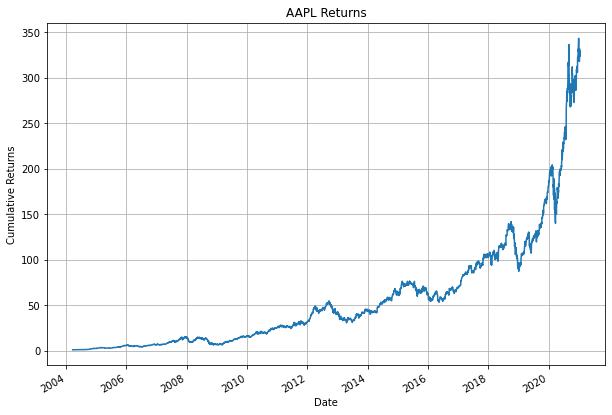

In [4]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Access the dataframe of AAPL from the dictionary 
# and then compute and plot the returns
(stock_data_dictionary['AAPL'].daily_pct_change+1).cumprod().plot()

# Set the title and axis lables and plot grid
plt.title('AAPL Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

## Split the data into train and test

In [5]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

for stock_name in stock_list:
    # Get predictor variables x
    X = stock_data_dictionary[stock_name][predictor_list]
    
    # Get the target variable y
    y = stock_data_dictionary[stock_name].actual_signal

    # Divide the dataset into train 80% and test 20%
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

[23:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.704297 using {'n_estimators': 5}
-0.704297 (0.006995) with: {'n_estimators': 5}
-0.714503 (0.010734) with: {'n_estimators': 10}
-0.722093 (0.010153) with: {'n_estimators': 15}
-0.730585 (0.009608) with: {'n_estimators': 20}
-0.739455 (0.010627) with: {'n_estimators': 25}
-0.746529 (0.012902) with: {'n_estimators': 30}
-0.752911 (0.016775) with: {'n_estimators': 35}
-0.761074 (0.019290) with: {'n_estimators': 40}
-0.767044 (0.020247) with: {'n_estimators': 45}
-0.774054 (0.020001) with: {'n_estimators': 50}
-0.781728 (0.021886) with: {'n_estimators': 55}
-0.786744 (0.024651) with: {'n_estimators': 60}
-0.794150 (0.025323) with: {'n_estimators': 65}
-0.799513 (0.025572) with

Text(0, 0.5, 'Log Loss')

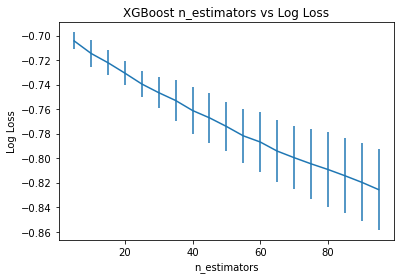

In [6]:
#finding the best n_estimator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

#grid search
model = XGBClassifier()
n_estimators = range(5, 100, 5)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
#plt.savefig('n_estimators.png')

range(1, 20)
Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s


[23:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.696109 using {'max_depth': 1}
-0.696109 (0.007317) with: {'max_depth': 1}
-0.718300 (0.013430) with: {'max_depth': 2}
-0.740290 (0.018226) with: {'max_depth': 3}
-0.769742 (0.026965) with: {'max_depth': 4}
-0.793070 (0.024926) with: {'max_depth': 5}
-0.831767 (0.032252) with: {'max_depth': 6}
-0.861209 (0.033403) with: {'max_depth': 7}
-0.879442 (0.033090) with: {'max_depth': 8}
-0.911146 (0.032443) with: {'max_depth': 9}
-0.938073 (0.049433) with: {'max_depth': 10}
-0.959263 (0.045821) with: {'max_depth': 11}
-0.959200 (0.058726) with: {'max_depth': 12}
-0.986943 (0.042619) with: {'max_depth': 13}
-1.003577 (0.046908) with: {'max_depth': 14}
-1.012618 (0.051270) with: {'m

[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:  1.4min finished


Text(0, 0.5, 'Log Loss')

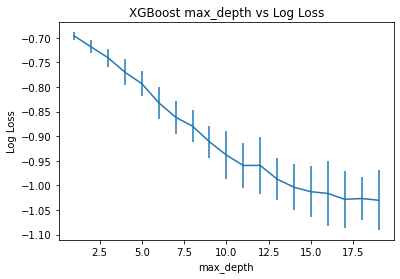

In [7]:
#finding the best max_depth

# grid search
model = XGBClassifier()
max_depth = range(1, 20, 1)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
#plt.savefig('max_depth.png')

In [8]:
# Initialize the model and set the hyperparameter values
model = XGBClassifier(max_depth=1, n_estimators=5)
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=1,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

## Cross Validation in Train dataset

In [9]:
# Initialize the KFold parameters
kfold = KFold(n_splits=7, random_state=5)

# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#room to optimization

[23:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

## Create the model

In [10]:
# Fit the model. train the XGBoost classifier using the fit method.
model.fit(X_train, y_train)

[23:04:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Feature Importance

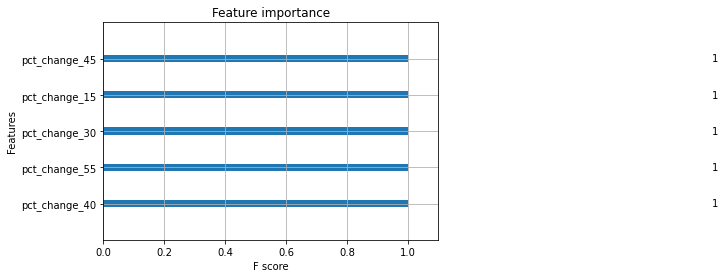

In [11]:
# Plot the top 7 features
xgboost.plot_importance(model, max_num_features=7)

# Show the plot
plt.show()

In [12]:
#The XGBoost python model tells us that the pct_change_40 is the most important feature of the others. 
#Since we had mentioned that we need only 7 features, we received this list. Here’s an interesting idea, why don’t you increase the number and see how the other features stack up, 
#when it comes to their f-score. You can also remove the unimportant features and then retrain the model. Would this increase the model accuracy?

## Predict

In [13]:
# Predict the trading signal on test datset
y_pred = model.predict(X_test)

## Classification Report

In [14]:
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.10      0.16      1927
           1       0.55      0.92      0.69      2308

    accuracy                           0.54      4235
   macro avg       0.52      0.51      0.43      4235
weighted avg       0.52      0.54      0.45      4235



In [15]:
#The f1-score for the long side is much more powerful compared to the short side. We can modify the model and make it a long-only strategy. 

## Confusion Matrix

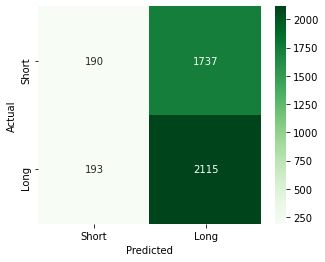

In [16]:
array = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
                  'Short', 'Long'])

plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
#XGBoost tended to predict “long” more times than “short”

## Individual stock performance

AAPL


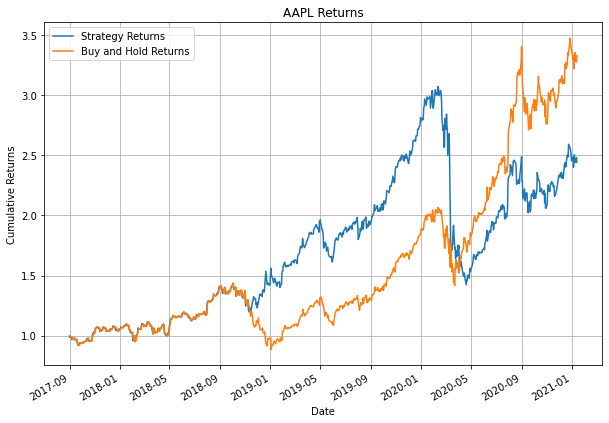

AMZN


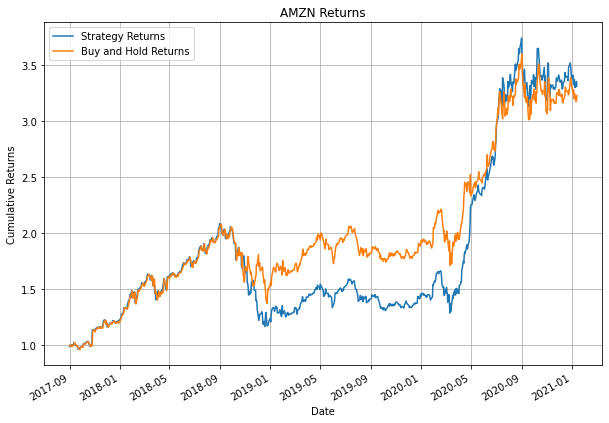

NFLX


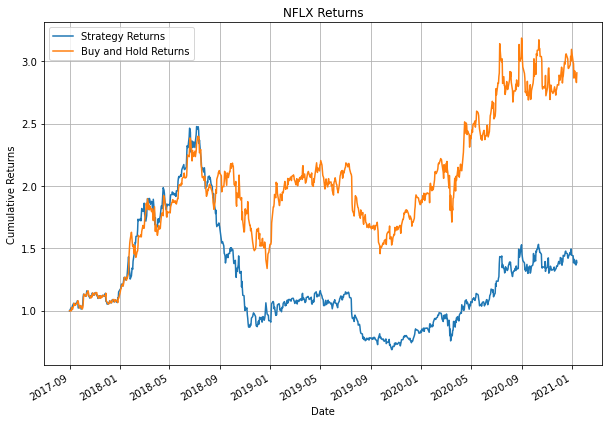

NVDA


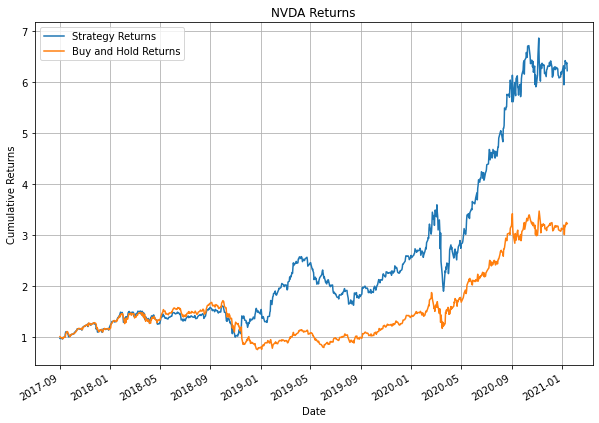

MSFT


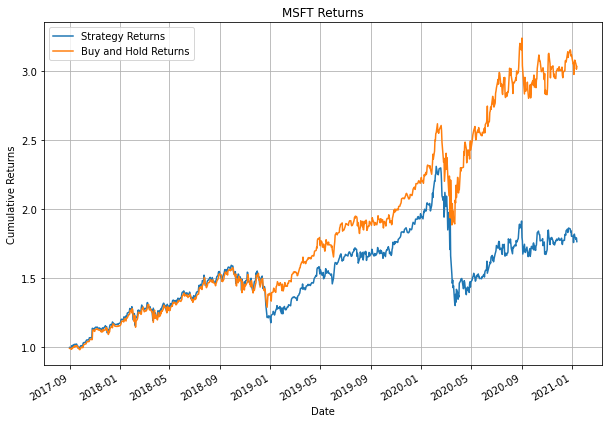

In [18]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)

# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
    
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]

    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal

    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    
    # Plot the stock strategy and buy and hold returns
    print(stock_name)
    
    # Set the figure size
    plt.figure(figsize=(10, 7))
    
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()    
    
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

## Performance of portfolio

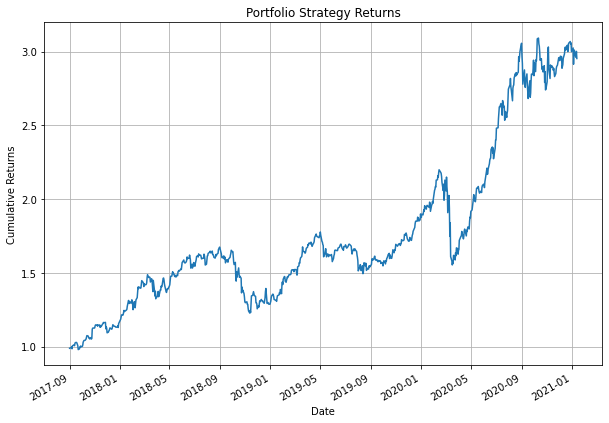

In [19]:
# Drop missing values
portfolio.dropna(inplace=True)

# Set the figure size
plt.figure(figsize=(10, 7))

# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()

# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [20]:
!pip install pyfolio

## Detailed performance analysis in test dataset

In [21]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))

Start date,2017-09-01
End date,2021-01-13
Total months,40
,Backtest
Annual return,38.0%
Cumulative returns,195.4%
Annual volatility,26.8%
Sharpe ratio,1.34
Calmar ratio,1.30
Stability,0.81
Max drawdown,-29.4%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'